In [1]:
import numpy as np
import pandas as pd
from sklearn.externals import joblib

In [2]:
with np.load('data/interim/kmers/kmer_matrix.npz') as data:
    kmers = data['kmers']
    kmer_order = data['kmer_order']
    genome_order = data['genome_order']

In [6]:
import os
print(os.getcwd())
micsdf = joblib.load('data/interim/mic_class_dataframe2.pkl')
class_orders = joblib.load('data/interim/mic_class_order_dict2.pkl')

/home/matt/workspace/n_phenores/phenores


In [7]:
# TIO
tio_labels = class_orders['TIO']
tio_label_index = { k: v for v, k in enumerate(tio_labels) }
y_tio = np.array([ tio_label_index[m] if not pd.isna(m) else m for m in micsdf.loc[genome_order, 'TIO'] ])
labels, counts = np.unique(y_tio, return_counts=True)
ok = labels[counts >= 5]

mask = np.in1d(y_tio, ok) # Since Nan is not a label, this also filters invalid MICs
y_tio = y_tio[mask]
X_tio = kmers[mask,:]
tio_samples = genome_order[mask]

In [8]:
# Distribution
np.unique(y_tio,return_counts=True)

(array([1., 2., 3., 4., 5., 6.]), array([ 505, 1308,   82,    7,   98,  257]))

In [9]:
# Test/train split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tio, y_tio, test_size=0.2, random_state=36, stratify=y_tio)


In [10]:
np.unique(y_test,return_counts=True)

(array([1., 2., 3., 4., 5., 6.]), array([101, 262,  16,   1,  20,  52]))

In [11]:
# Upsampler
from imblearn.over_sampling import SMOTE

def keep_proportions(y):
    tot = y.shape[0]
    l, n = np.unique(y,return_counts=True)
    
    mn = np.min(n) # Set a floor for the distribution
    floor = 30
    
    proportions = {}
    for label,count in zip(l,n):
        proportions[label] = count*floor/mn
    
    return proportions

def set_floor(y):
    tot = y.shape[0]
    l, n = np.unique(y,return_counts=True)
    
    mn = np.min(n) # Set a floor for the distribution
    floor = 30
    
    proportions = {}
    for label,count in zip(l,n):
        proportions[label] = count if count > floor else floor
    
    return proportions
    
upsampler = SMOTE(ratio=set_floor, kind='borderline2', k_neighbors=2, m_neighbors=2)

In [11]:
# Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

fvals, pvals = f_classif(X_train, y_train)



/home/matt/anaconda3/envs/phenores/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 149082  195348  257056 ... 2008529 2008530 2008531] are constant.
  UserWarning)
/home/matt/anaconda3/envs/phenores/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/home/matt/anaconda3/envs/phenores/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


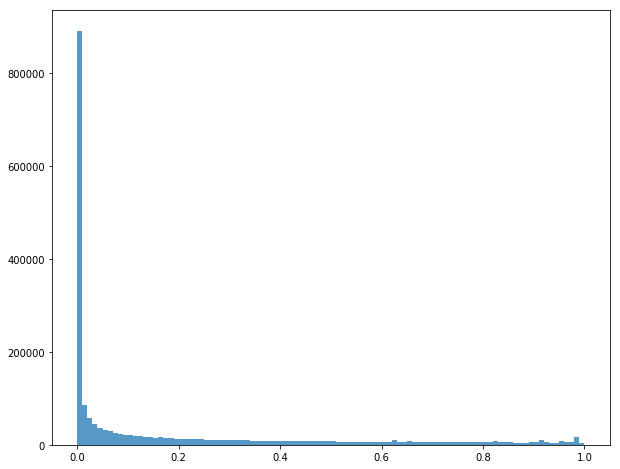

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8))
n_bins=100
pvals = pvals[~np.isnan(pvals)]
n, bins, patches = ax.hist(pvals, n_bins, alpha=0.75, label='F-value')
plt.show()

In [12]:
k = -200000
topf = np.argpartition(fvals, k)[k:]
fvals[topf]

array([11.738969, 11.738975, 11.739001, ..., 28.723146, 24.650064,
       21.250961], dtype=float32)

In [13]:
X_ftest = X_tio[:,topf]


In [14]:
from sklearn.neighbors import NearestNeighbors
nb = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(X_ftest)

In [15]:
nb_dist, nb_i = nb.kneighbors(X_ftest)

In [31]:
def cohesion(cl, y=y_tio):
    u = np.unique(y[cl])
    if len(u) == 1:
        return True
    else:
        return False

In [39]:
res = np.apply_along_axis(cohesion, 1, nb_i)

In [42]:
sum(res)

793

In [45]:
topf2 = np.argpartition(fvals, -200)[-200:]
X_ftest2 = X_tio[:,topf2]

In [48]:
nb = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(X_ftest2)
nb_dist2, nb_i2 = nb.kneighbors(X_ftest2)
res2 = np.apply_along_axis(cohesion, 1, nb_i2)

In [49]:
sum(res2)

4

In [53]:
mi = mutual_info_classif(X_train, y_train, discrete_features=True)

In [2]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8))
n_bins=100
mi = mi[~np.isnan(mi)]
n, bins, patches = ax.hist(mi, n_bins, alpha=0.75, label='F-value')
plt.show()

NameError: name 'mi' is not defined